In [1]:
!pip install pandas numpy matplotlib tensorflow tkan==0.3.0 sigkan==0.1.5 tkat==0.1.1 scikit-learn pyarrow

In [2]:
import time
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Flatten, Input

from tkan import TKAN
from tkat import TKAT
from sigkan import SigKAN

from sklearn.metrics import r2_score

tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()


2024-06-22 11:52:29.996228: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
class MinMaxScaler:
    def __init__(self, feature_axis=None, minmax_range=(0, 1)):
        """
        Initialize the MinMaxScaler.
        Args:
        feature_axis (int, optional): The axis that represents the feature dimension if applicable.
                                      Use only for 3D data to specify which axis is the feature axis.
                                      Default is None, automatically managed based on data dimensions.
        """
        self.feature_axis = feature_axis
        self.min_ = None
        self.max_ = None
        self.scale_ = None
        self.minmax_range = minmax_range # Default range for scaling (min, max)

    def fit(self, X):
        """
        Fit the scaler to the data based on its dimensionality.
        Args:
        X (np.array): The data to fit the scaler on.
        """
        if X.ndim == 3 and self.feature_axis is not None:  # 3D data
            axis = tuple(i for i in range(X.ndim) if i != self.feature_axis)
            self.min_ = np.min(X, axis=axis)
            self.max_ = np.max(X, axis=axis)
        elif X.ndim == 2:  # 2D data
            self.min_ = np.min(X, axis=0)
            self.max_ = np.max(X, axis=0)
        elif X.ndim == 1:  # 1D data
            self.min_ = np.min(X)
            self.max_ = np.max(X)
        else:
            raise ValueError("Data must be 1D, 2D, or 3D.")

        self.scale_ = self.max_ - self.min_
        return self

    def transform(self, X):
        """
        Transform the data using the fitted scaler.
        Args:
        X (np.array): The data to transform.
        Returns:
        np.array: The scaled data.
        """
        X_scaled = (X - self.min_) / self.scale_
        X_scaled = X_scaled * (self.minmax_range[1] - self.minmax_range[0]) + self.minmax_range[0]
        return X_scaled

    def fit_transform(self, X):
        """
        Fit to data, then transform it.
        Args:
        X (np.array): The data to fit and transform.
        Returns:
        np.array: The scaled data.
        """
        return self.fit(X).transform(X)

    def inverse_transform(self, X_scaled):
        """
        Inverse transform the scaled data to original data.
        Args:
        X_scaled (np.array): The scaled data to inverse transform.
        Returns:
        np.array: The original data scale.
        """
        X = (X_scaled - self.minmax_range[0]) / (self.minmax_range[1] - self.minmax_range[0])
        X = X * self.scale_ + self.min_
        return X

In [4]:
df = pd.read_parquet('/workspace/data.parquet')
df = df[(df.index >= pd.Timestamp('2020-01-01')) & (df.index < pd.Timestamp('2023-01-01'))]
assets = ['BTC', 'ETH', 'ADA', 'XMR', 'EOS', 'MATIC', 'TRX', 'FTM', 'BNB', 'XLM', 'ENJ', 'CHZ', 'BUSD', 'ATOM', 'LINK', 'ETC', 'XRP', 'BCH', 'LTC']
df = df[[c for c in df.columns if 'quote asset volume' in c and any(asset in c for asset in assets)]]
df.columns = [c.replace(' quote asset volume', '') for c in df.columns]
known_input_df = pd.DataFrame(index=df.index, data=np.array([df.reset_index()['group'].apply(lambda x: (x.hour)).values, df.reset_index()['group'].apply(lambda x: (x.dayofweek)).values]).T, columns = ['hour', 'dayofweek'])
display(df)
display(known_input_df)

,BTC,ADA,XMR,EOS,CHZ,MATIC,TRX,ENJ,FTM,BNB,XLM,BUSD,ATOM,LTC,LINK,ETC,ETH,XRP,BCH
group,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,3.675857e+06,38189.176211,4.539598e+04,94778.577031,817.146319,31003.791035,481993.354990,15241.945783,1165.788613,8.498617e+05,9460.819556,1.352376e+04,31986.972694,1.165827e+05,24281.170262,56488.402352,1.000930e+06,2.579254e+05,178258.749391
2020-01-01 01:00:00,6.365953e+06,51357.010954,3.348395e+04,593292.135445,886.460339,84465.335718,533668.554562,11896.843688,413.844612,7.405759e+05,37141.909518,2.531605e+04,81777.666046,2.830715e+05,51190.975142,182102.074213,1.474278e+06,4.520609e+05,615321.025242
2020-01-01 02:00:00,4.736719e+06,36164.263914,1.573255e+04,266732.556000,1819.795050,113379.718506,387049.986770,30109.770521,3559.965968,1.039091e+06,16878.822627,1.390886e+04,195731.175551,2.402871e+05,28721.756184,134063.422732,9.940256e+05,4.414948e+05,221535.645771
2020-01-01 03:00:00,5.667367e+06,24449.953815,2.575105e+04,124516.579473,2979.655803,41771.707995,450772.139235,6732.833578,4076.415482,4.975018e+05,9049.223394,2.251969e+04,120113.343316,1.613043e+05,29596.222534,131094.172168,6.473610e+05,1.886061e+05,397185.950571
2020-01-01 04:00:00,3.379094e+06,44502.669843,6.295563e+04,421819.671410,1023.388675,22254.756114,284788.973752,846.938455,633.367505,4.751285e+05,7254.260203,1.122460e+04,19989.169106,2.214516e+05,54514.370016,134937.122201,4.430067e+05,2.279373e+05,316499.137509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,6.704605e+07,581680.400510,3.873989e+05,48359.865300,199491.822800,890911.573610,225136.420055,40281.859330,159553.944500,9.889098e+05,39230.588600,6.560756e+06,180809.784710,9.964355e+05,190664.976300,181340.756100,7.738029e+06,1.413563e+06,35409.149500
2022-12-31 20:00:00,4.344849e+07,323561.762270,1.379392e+05,37858.704700,173057.240300,333511.762200,157069.026827,42228.830930,270251.374500,6.032059e+05,52964.531800,7.255324e+06,276013.421720,1.173164e+06,265727.950340,90513.087600,4.278879e+06,1.113527e+06,42674.516600
2022-12-31 21:00:00,5.992803e+07,455185.698060,2.445869e+05,79538.050600,107544.609700,525037.759990,180404.744820,27446.620810,198885.610000,1.386864e+06,44485.594800,8.712142e+06,476151.071190,6.820723e+05,265687.852060,85399.066100,4.643401e+06,1.373231e+06,38027.858800


,hour,dayofweek
group,,
2020-01-01 00:00:00,0,2
2020-01-01 01:00:00,1,2
2020-01-01 02:00:00,2,2
2020-01-01 03:00:00,3,2
2020-01-01 04:00:00,4,2
...,...,...
2022-12-31 19:00:00,19,5
2022-12-31 20:00:00,20,5
2022-12-31 21:00:00,21,5


In [5]:
N_MAX_EPOCHS = 100
BATCH_SIZE = 128
early_stopping_callback = lambda : tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=6,
    mode="min",
    restore_best_weights=True,
    start_from_epoch=6,
)
lr_callback = lambda : tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=3,
    mode="min",
    min_delta=0.00001,
    min_lr=0.000025,
    verbose=0,
)
callbacks = lambda : [early_stopping_callback(), lr_callback(), tf.keras.callbacks.TerminateOnNaN()]


In [6]:
def generate_data(df, sequence_length, n_ahead):
    #Case without known inputs
    scaler_df = df.copy().shift(n_ahead).rolling(24 * 14).median()
    tmp_df = df.copy() / scaler_df
    tmp_df = tmp_df.iloc[24 * 14 + n_ahead:].fillna(0.)
    scaler_df = scaler_df.iloc[24 * 14 + n_ahead:].fillna(0.)
    def prepare_sequences(df, scaler_df, n_history, n_future):
        X, y, y_scaler = [], [], []
        num_features = df.shape[1]
        
        # Iterate through the DataFrame to create sequences
        for i in range(n_history, len(df) - n_future + 1):
            # Extract the sequence of past observations
            X.append(df.iloc[i - n_history:i].values)
            # Extract the future values of the first column
            y.append(df.iloc[i:i + n_future,0:1].values)
            y_scaler.append(scaler_df.iloc[i:i + n_future,0:1].values)
        
        X, y, y_scaler = np.array(X), np.array(y), np.array(y_scaler)
        return X, y, y_scaler
    
    # Prepare sequences
    X, y, y_scaler = prepare_sequences(tmp_df, scaler_df, sequence_length, n_ahead)
    
    # Split the dataset into training and testing sets
    train_test_separation = int(len(X) * 0.8)
    X_train_unscaled, X_test_unscaled = X[:train_test_separation], X[train_test_separation:]
    y_train_unscaled, y_test_unscaled = y[:train_test_separation], y[train_test_separation:]
    y_scaler_train, y_scaler_test = y_scaler[:train_test_separation], y_scaler[train_test_separation:]
    
    # Generate the data
    X_scaler = MinMaxScaler(feature_axis=2)
    X_train = X_scaler.fit_transform(X_train_unscaled)
    X_test = X_scaler.transform(X_test_unscaled)
    
    y_scaler = MinMaxScaler(feature_axis=2)
    y_train = y_scaler.fit_transform(y_train_unscaled)
    y_test = y_scaler.transform(y_test_unscaled)
    
    y_train = y_train.reshape(y_train.shape[0], -1) 
    y_test = y_test.reshape(y_test.shape[0], -1)
    return X_scaler, X_train, X_test, X_train_unscaled, X_test_unscaled, y_scaler, y_train, y_test, y_train_unscaled, y_test_unscaled, y_scaler_train, y_scaler_test

def generate_data_w_known_inputs(df, known_input_df, sequence_length, n_ahead):
    #Case without known inputs - fill with 0 the unknown features future values in X
    scaler_df = df.copy().shift(n_ahead).rolling(24 * 14).median()
    tmp_df = df.copy() / scaler_df
    tmp_df = tmp_df.iloc[24 * 14 + n_ahead:].fillna(0.)
    scaler_df = scaler_df.iloc[24 * 14 + n_ahead:].fillna(0.)
    tmp_known_input_df = known_input_df.iloc[24 * 14 + n_ahead:].copy()
    def prepare_sequences(df, known_input_df, scaler_df, n_history, n_future):
        Xu, Xk, y, y_scaler = [], [], [], []
        num_features = df.shape[1]
        
        # Iterate through the DataFrame to create sequences
        for i in range(n_history, len(df) - n_future + 1):
            # Extract the sequence of past observations
            Xu.append(np.concatenate((df.iloc[i - n_history:i].values, np.zeros((n_future, df.shape[1]))), axis=0))
            Xk.append(known_input_df.iloc[i - n_history:i+n_future].values)
            # Extract the future values of the first column
            y.append(df.iloc[i:i + n_future,0:1].values)
            y_scaler.append(scaler_df.iloc[i:i + n_future,0:1].values)
        
        Xu, Xk, y, y_scaler = np.array(Xu), np.array(Xk), np.array(y), np.array(y_scaler)
        return Xu, Xk, y, y_scaler
    
    # Prepare sequences
    Xu, Xk, y, y_scaler = prepare_sequences(tmp_df, tmp_known_input_df, scaler_df, sequence_length, n_ahead)

    X = np.concatenate((Xu, Xk), axis=-1)
    
    # Split the dataset into training and testing sets
    train_test_separation = int(len(X) * 0.8)
    X_train_unscaled, X_test_unscaled = X[:train_test_separation], X[train_test_separation:]
    y_train_unscaled, y_test_unscaled = y[:train_test_separation], y[train_test_separation:]
    y_scaler_train, y_scaler_test = y_scaler[:train_test_separation], y_scaler[train_test_separation:]
    
    # Generate the data
    X_scaler = MinMaxScaler(feature_axis=2)
    X_train = X_scaler.fit_transform(X_train_unscaled)
    X_test = X_scaler.transform(X_test_unscaled)
    
    y_scaler = MinMaxScaler(feature_axis=2)
    y_train = y_scaler.fit_transform(y_train_unscaled)
    y_test = y_scaler.transform(y_test_unscaled)
    
    y_train = y_train.reshape(y_train.shape[0], -1) 
    y_test = y_test.reshape(y_test.shape[0], -1)
    return X_scaler, X_train, X_test, X_train_unscaled, X_test_unscaled, y_scaler, y_train, y_test, y_train_unscaled, y_test_unscaled, y_scaler_train, y_scaler_test

In [7]:
n_ahead = 30
sequence_length = 5 * n_ahead

X_scaler, X_train, X_test, X_train_unscaled, X_test_unscaled, y_scaler, y_train, y_test, y_train_unscaled, y_test_unscaled, y_scaler_train, y_scaler_test = generate_data(df, sequence_length, n_ahead)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20607, 150, 19), (5152, 150, 19), (20607, 30), (5152, 30))

# SigKAN usage

In [8]:

num_unknow_features = len(assets)
num_know_features = X_train.shape[2] - num_unknow_features

model  = Sequential([
    Input(shape=X_train.shape[1:]),
    SigKAN(100, 2, dropout = 0.),
    Flatten(),
    Dense(100, 'relu'),
    Dense(units=n_ahead, activation='linear')
])


model.compile(optimizer='adam', loss='mean_squared_error', jit_compile = False)

model.summary()

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_MAX_EPOCHS, validation_split=0.2, callbacks=callbacks(), shuffle=True, verbose = False)

preds = model.predict(X_test).flatten()
errors = preds - y_test.flatten()
rmse = np.sqrt(np.mean(np.square(errors)))
r2 = r2_score(y_true=y_test.flatten(), y_pred=preds)
mae = np.mean(np.abs(errors))

metrics_summary = f"""
Model Type: SigKAN
------------------------------------
Root Mean Squared Error (RMSE): {rmse:.4f}
R-squared (R²) Score: {r2:.4f}
Mean Absolute Error (MAE): {mae:.4f}
"""
print(metrics_summary)

all_errors = {}
preds = model.predict(X_test)
errors = preds-y_test
all_errors['SigKAN'] = errors

2024-06-22 11:52:46.285074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8231 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:41:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sig_kan (SigKAN)                │ (None, 150, 100)       │       513,738 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     1,500,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,016,868 (7.69 MB)

 Trainable params: 2,010,880 (7.67 MB)

 Non-trainable params: 5,988 (23.39 KB)

161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step

Model Type: SigKAN
------------------------------------
Root Mean Squared Error (RMSE): 0.0678
R-squared (R²) Score: 0.1028
Mean Absolute Error (MAE): 0.0304

161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step


## Other example comparison

In [10]:
models = ['TKAT', 'TKAN', 'MLP', 'GRU', 'LSTM']


for model_type in models:

    if model_type == "TKAT":
        X_scaler, X_train, X_test, X_train_unscaled, X_test_unscaled, y_scaler, y_train, y_test, y_train_unscaled, y_test_unscaled, y_scaler_train, y_scaler_test = generate_data_w_known_inputs(df, known_input_df, sequence_length, n_ahead)
    else:
        X_scaler, X_train, X_test, X_train_unscaled, X_test_unscaled, y_scaler, y_train, y_test, y_train_unscaled, y_test_unscaled, y_scaler_train, y_scaler_test = generate_data(df, sequence_length, n_ahead)

    if model_type == "TKAT":
        num_unknow_features = len(assets)
        num_know_features = X_train.shape[2] - num_unknow_features
        model = TKAT(sequence_length, num_unknow_features, num_know_features, 1, 100, 4, n_ahead, use_tkan = True)
    elif 'TKAN' in model_type:
        model = Sequential([
            Input(shape=X_train.shape[1:]),
            TKAN(100, tkan_activations=[{'grid_size': 3} for i in range(5)], sub_kan_output_dim = 20, sub_kan_input_dim = 1, return_sequences=True),
            TKAN(100, tkan_activations=[{'grid_size': 3} for i in range(5)], sub_kan_output_dim = 20, sub_kan_input_dim = 1, return_sequences=False),
            Dense(units=n_ahead, activation='linear')
        ])
    elif 'GRU' in model_type:
        model = Sequential([
            Input(shape=X_train.shape[1:]),
            GRU(100, return_sequences=True),
            GRU(100, return_sequences=False),
            Dense(units=n_ahead, activation='linear')
        ])
    elif 'LSTM' in model_type:
        model = Sequential([
            Input(shape=X_train.shape[1:]),
            LSTM(100, return_sequences=True),
            LSTM(100, return_sequences=False),
            Dense(units=n_ahead, activation='linear')
        ])
    elif 'MLP' in model_type:
        model = Sequential([
            Input(shape=X_train.shape[1:]),
            Flatten(),
            Dense(100, activation='relu'),
            Dense(100, activation='relu'),
            Dense(units=n_ahead, activation='linear')
        ])
    
    optimizer = tf.keras.optimizers.Adam(0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    model.summary()

    history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_MAX_EPOCHS, validation_split=0.2, callbacks=callbacks(), shuffle=True, verbose = False)
    preds = model.predict(X_test)
    errors = preds-y_test
    all_errors[model_type] = errors


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 180, 21)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 180, 1,    │          0 │ input_layer_1[0]… │
│ (EmbeddingLayer)    │ 21)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ past_observed_and_… │ (None, 150, 1,    │          0 │ embedding_layer[… │
│ (Lambda)            │ 21)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vsn_past_features   │ (None, 150, 100)  │    665,946 │ past_observed_an… │
│ (VariableSelection… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_known        │ (None, 30, 1, 2)  │          0 │ embedding_layer[… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 150,      │     71,612 │ vsn_past_feature… │
│ (RecurrentLayer)    │ 100), (None,      │            │                   │
│                     │ 100), (None,      │            │                   │
│                     │ 100), (None,      │            │                   │
│                     │ 100)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vsn_future_features │ (None, 30, 100)   │     72,614 │ future_known[0][… │
│ (VariableSelection… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 30, 100)   │     71,612 │ vsn_future_featu… │
│ (RecurrentLayer)    │                   │            │ encoder[0][1],    │
│                     │                   │            │ encoder[0][2],    │
│                     │                   │            │ encoder[0][3]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 180, 100)  │          0 │ encoder[0][0],    │
│ (Concatenate)       │                   │            │ decoder[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gate_26 (Gate)      │ (None, 180, 100)  │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 180, 100)  │          0 │ vsn_past_feature… │
│ (Concatenate)       │                   │            │ vsn_future_featu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_and_norm_26     │ (None, 180, 100)  │        200 │ gate_26[0][0],    │
│ (AddAndNorm)        │                   │            │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ grn_25 (GRN)        │ (None, 180, 100)  │          0 │ add_and_norm_26[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 180, 100)  │    161,300 │ grn_25[0][0],     │
│ (MultiHeadAttentio… │                   │            │ grn_25[0][0],     │
│                     │                   │            │ grn_25[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 18000)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_156 (Dense)   │ (None, 30)        │    540,030 │ flatten_1[0][0] 

 Total params: 1,583,314 (6.04 MB)

 Trainable params: 1,583,294 (6.04 MB)

 Non-trainable params: 20 (80.00 B)

I0000 00:00:1719058103.928264   83077 service.cc:145] XLA service 0x7f719cb061d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719058103.928408   83077 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-06-22 12:08:27.672569: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-22 12:08:36.627668: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1719058163.240893   83077 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_93', 48 bytes spill stores, 48 bytes spill loads

I0000 00:00:1719058163.478119   83077 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
I0000 00:00:1719058236.245351   83078 asm

161/161 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tkan_2 (TKAN)                   │ (None, 150, 100)       │        47,345 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tkan_3 (TKAN)                   │ (None, 100)            │        72,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,425 (478.22 KB)

 Trainable params: 122,325 (477.83 KB)

 Non-trainable params: 100 (400.00 B)

161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 2850)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 100)            │       285,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 298,230 (1.14 MB)

 Trainable params: 298,230 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 150, 100)       │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,930 (390.35 KB)

 Trainable params: 99,930 (390.35 KB)

 Non-trainable params: 0 (0.00 B)

161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150, 100)       │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,430 (513.40 KB)

 Trainable params: 131,430 (513.40 KB)

 Non-trainable params: 0 (0.00 B)

161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


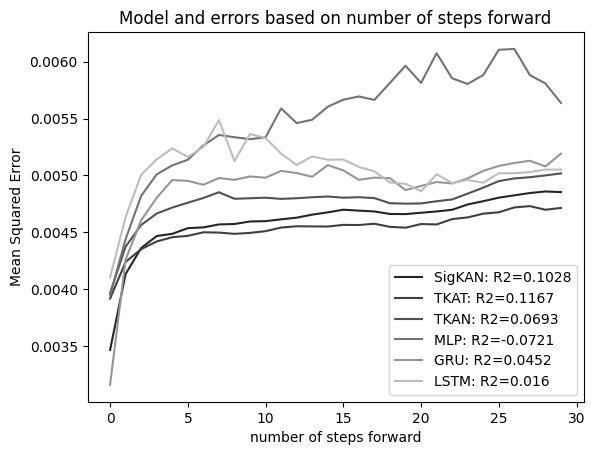

In [12]:
model_types = ['SigKAN', 'TKAT', 'TKAN', 'MLP', 'GRU', 'LSTM']
grey_shades = ['#252525', '#404040', '#525252', '#737373', '#969696', '#bdbdbd']  # Darker to lighter

for model_type, color in zip(model_types, grey_shades):
    y_pred = all_errors[model_type] + y_test
    r2 = r2_score(y_true=y_test.flatten(), y_pred=y_pred.flatten())
    plt.plot(np.mean(all_errors[model_type]**2, axis=0), label=f'{model_type}: R2={round(r2,4)}', color=color)

plt.legend()
plt.title('Model and errors based on number of steps forward')
plt.xlabel('number of steps forward')
plt.ylabel('Mean Squared Error')
plt.savefig('model_and_errors_sigkan.png')
plt.show()